In [1]:

import datetime
import pandas as pd

import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from LTSF_LinearModel_lib import LTSF_FF_DLinear
from sklearn.preprocessing import MinMaxScaler

import plotly
import plotly.graph_objects as go
import plotly.express as px
# 调用BTC爬取部分
import sys
sys.path.append("E:/Python_WorkSpace/量化交易/")  # 增加指定的绝对路径,进入系统路径,从而便于该目录下的库调用

from BTCCrawl_To_DataFrame_Class import BTC_data_acquire as BTC
from BTCCrawl_To_DataFrame_Class import get_api_key
Folder_base = "E:/Python_WorkSpace/量化交易/data/"
config_file_path = "E:/Python_WorkSpace/量化交易/BTCCrawl_To_DataFrame_Class_config.ini"
# URL = "https://api.coincap.io/v2/candles?exchange=binance&interval=h12&baseId=bitcoin&quoteId=tether"
URL = 'https://data.binance.com'
StartDate = "2022-11-20"
EndDate = "2023-03-01"
BTC_json = "BTC_h12.json"
BinanceBTC_json = "BinanceBTC_h12.json"

api_key, api_secret = get_api_key(config_file_path)

In [2]:
BTC_data = BTC(URL, StartDate, EndDate, Folder_base, BTC_json,
               binance_api_key=api_key, binance_api_secret=api_secret)
data0 = BTC_data.MarketFactor_ClosePriceFeatures(by_BinanceAPI=True,
    FromWeb=False,close_colName='close',lags=0,window=20,DayH=2, MarketFactor=True, weekdays=7,)
# data0["year"] = (
#     data0["year"] - 2016
# )  # 因为数据从2016年开始,减去2016,将年份变成0以上的整数,以使得Embedding词汇表范围缩小


def dataset_Scaler(data):
    # 将原始数据MinMax归一化,以提高特征辨识度; 注意:要小心,重复归一化,可能会导致数据变小
    # 将close_price单独归一化,因为后面需要将close_price预测出后,还原
    X_Scaler = MinMaxScaler()
    y_Scaler = MinMaxScaler()

    X_ds = X_Scaler.fit_transform(
        data[data.columns[:-1]]
    )  # 本是DataFrame的类型,经过转换,X变成了ndarray类型;
    y_ds = y_Scaler.fit_transform(
        data["close"].to_numpy().reshape(-1, 1)
    )  # y为series,标准化需要(-1,1)的shape
    data = np.c_[X_ds, y_ds]

    return data, X_Scaler, y_Scaler


data, X_Scaler, y_Scaler = dataset_Scaler(data0)
print(type(data))
print("data.shape={}".format(data.shape))
print("最后两行数据:\n{}".format(data[-2:, :]))

Binance Rest API 联通测试通过 !
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3992 entries, 2017-08-17 00:00:00+00:00 to 2023-02-03 00:00:00+00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        3992 non-null   float32
 1   high        3992 non-null   float32
 2   low         3992 non-null   float32
 3   close       3992 non-null   float32
 4   volume      3992 non-null   float32
 5   amount      3992 non-null   float32
 6   num_trades  3992 non-null   float32
 7   bid_volume  3992 non-null   float32
 8   bid_amount  3992 non-null   float32
dtypes: float32(9)
memory usage: 171.5 KB
从web中读出Data.info:None
BTC数据合并存入:E:/Python_WorkSpace/量化交易/data/BinanceBTC_h12.json


,log_return,Roll_price_sma,Roll_price_min,Roll_price_max,Roll_return_mom,Roll_return_std,Mark_return,d_amplitude,volume,RSI_7,...,high_pre_close,low_pre_close,high,low,open,amount,num_trades,bid_volume,bid_amount,close
count,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,...,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3.958000e+03,3.958000e+03,3958.000000,3.958000e+03,3958.000000
mean,0.000419,19524.773066,18041.433135,21019.626904,0.000416,0.025382,0.525013,822.892029,36038.406250,51.661140,...,1.019639,0.978810,19952.273438,19129.390625,19564.921875,7.696118e+08,6.625322e+05,17933.429688,3.811720e+08,19569.742188
std,0.028596,16572.614889,15350.890577,17825.753531,0.006604,0.013094,0.499437,1003.168396,39833.667969,13.928853,...,0.022351,0.025552,16936.292969,16235.105469,16607.675781,9.680476e+08,8.871228e+05,19755.556641,4.788796e+08,16606.134766
min,-0.268357,3359.310486,2919.000000,3504.770020,-0.034640,0.003899,0.000000,17.820068,127.036331,10.604572,...,0.998651,0.699475,3249.000000,2817.000000,2870.899902,5.881363e+05,1.007000e+03,55.618614,2.577815e+05,2919.000000
25%,-0.010006,7365.368378,6735.000000,8059.979980,-0.003078,0.016689,0.000000,194.652466,14796.493896,41.878640,...,1.005836,0.973590,7541.964966,7275.552368,7389.625000,1.234654e+08,1.288170e+05,7586.004395,6.426903e+07,7391.865112
50%,0.000795,10691.134790,9966.530273,11528.250000,0.000492,0.023021,1.000000,416.659912,23630.557617,50.576717,...,1.012710,0.986596,11029.654785,10562.500000,10798.834961,2.989546e+08,3.331350e+05,11835.131348,1.504583e+08,10808.020020
75%,0.012285,31058.163867,28715.320312,34258.988281,0.004020,0.031014,1.000000,1147.425781,39806.104492,61.130992,...,1.025559,0.993800,31737.980469,29843.435547,30815.485352,1.167595e+09,7.901168e+05,19614.153809,5.755117e+08,30815.502930
max,0.237092,64595.437500,60574.488281,67594.976562,0.027119,0.104382,1.000000,11858.800781,474581.750000,94.898909,...,1.321000,1.000920,69000.000000,67015.203125,67594.976562,9.054959e+09,8.848036e+06,235625.812500,4.496810e+09,67594.976562


,log_return,Roll_price_sma,Roll_price_min,Roll_price_max,Roll_return_mom,Roll_return_std,Mark_return,d_amplitude,volume,RSI_7,...,high_pre_close,low_pre_close,high,low,open,amount,num_trades,bid_volume,bid_amount,close
2017-09-03 08:00:00+08:00,0.003094,4475.064014,4280.680176,4834.910156,0.003270,0.021080,1,257.959961,335.535156,57.173478,...,1.054251,0.996570,4714.759766,4456.799805,4508.50000,1541936.75,2991.0,123.085823,565981.3750,4486.000000
2017-09-03 20:00:00+08:00,0.005132,4484.717529,4280.680176,4834.910156,0.002188,0.020353,1,285.509766,355.681030,58.092390,...,1.021810,0.958165,4583.839844,4298.330078,4475.22998,1579116.00,3031.0,135.848709,603663.3125,4509.080078


,log_return,Roll_price_sma,Roll_price_min,Roll_price_max,Roll_return_mom,Roll_return_std,Mark_return,d_amplitude,volume,RSI_7,...,high_pre_close,low_pre_close,high,low,open,amount,num_trades,bid_volume,bid_amount,close
2023-02-02 20:00:00+08:00,-0.014016,23122.327637,22598.470703,23820.490234,0.001234,0.012837,0,781.349609,231634.671875,62.829218,...,1.013607,0.980806,24144.619141,23363.269531,23820.490234,5.509089e+09,5610778.0,115050.062500,2.736556e+09,23488.939453
2023-02-03 08:00:00+08:00,0.001003,23152.069629,22598.470703,23820.490234,0.001281,0.012834,1,178.638672,59731.914062,63.110775,...,1.004307,0.996702,23590.109375,23411.470703,23489.330078,1.404998e+09,1594179.0,29920.123047,7.037849e+08,23512.500000


<class 'numpy.ndarray'>
data.shape=(3958, 24)
最后两行数据:
[[0.50319753 0.3227346  0.34132866 0.31698634 0.58086103 0.08894926
  0.         0.06448195 0.48794464 0.61955107 0.56821127 0.07434574
  0.55184607 0.66961518 0.04639618 0.93327198 0.31779926 0.32004431
  0.32367538 0.60838036 0.6340853  0.48815362 0.60853245 0.31804606]
 [0.53291171 0.3232203  0.34132866 0.31698634 0.58162992 0.08892097
  1.         0.01358153 0.12562817 0.62289124 0.58169162 0.01228501
  0.56814218 0.67029337 0.01754548 0.98600569 0.30936578 0.32079513
  0.31855889 0.15510849 0.18007989 0.1267754  0.15645922 0.31841037]]


In [5]:
# best hyperparameter-----
Batch_size = 32
kernel_size = 47
L_seq = 208
individual = (False,)
L_pred = 7
out_features = 1
in_features = data.shape[1]


def gen(data):
    for i in range(data.shape[0]):
        yield data[i, :]


def xs_ys_dataset(
    data,
    L_seq,
    L_pred,
    Batch_size,
    out_features=1,
    shuffle=False,
    buffer_size=10000,
):
    """
    生产xs与ys合并一起的dataset,样本总长度:L_seq+L_pred.
    args:
        data: Dataframe格式的数据(B,in_features);
        L_seq: Linear模型输入的时序长度;
        L_pred: Linear模型输出的预测时序长度;
        out_features: target输出时的特征数,缺省=1,只取收盘价格
        Batch_size:
        shuffle: bool ; 是否shuffle
    out:
        (xs,ys): (input, target) ((B,L_seq,features),(B,L_pred,out_features))

    """
    output_signature = tf.TensorSpec((in_features), tf.float64)  # 14列
    # gen_f = gen(data)
    x_y = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature,
        args=(data,),
    )  # args用于给gen传递参数,必须是元组的形式传入参数;
    # x_y = tf.data.Dataset.from_tensor_slices(data)
    x_y = x_y.window(L_seq + L_pred, shift=1, drop_remainder=True)
    x_y = x_y.flat_map(lambda w: w.batch(L_seq + L_pred, drop_remainder=True))
    xs = x_y.map(lambda w: w[:L_seq, :])  # 时序L_seq;in_features中,不包含时间戳部分;
    ys = x_y.map(
        lambda w: w[L_seq:, (out_features * -1):]
    )  # 时序L_pred部分;in_features中,不包含时间戳部分;作为Target标签,这里只取最后的收盘价格,shape(B,L,1)

    dataset = tf.data.Dataset.zip((xs, ys))
    if shuffle == True:
        dataset.shuffle(buffer_size)

    return dataset.batch(Batch_size, drop_remainder=True).prefetch(1)


def xs_dataset(data, L_seq, Batch_size, shuffle=False, buffer_size=10000,):
    """
    仅生产xs的dataset,不包含标签;dataset时序长度:L_seq
    args:
        data: Dataframe格式的数据(B,in_features);
        L_seq: Linear模型输入的时序长度;
        Batch_size:
        shuffle: bool ; 是否shuffle
    out:
        xs: input (B,L_seq,features)
    """
    output_signature = tf.TensorSpec((in_features), tf.float64)  # 14列
    # gen_f = gen(data)
    xs = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature,
        args=(data,),
    )  # args用于给gen传递参数,必须是元组的形式传入参数;
    # xs = tf.data.Dataset.from_tensor_slices(data)
    xs = xs.window(L_seq, shift=1, drop_remainder=True)
    xs = xs.flat_map(lambda w: w.batch(L_seq, drop_remainder=True))

    if shuffle == True:
        xs.shuffle(buffer_size)

    return xs.batch(Batch_size, drop_remainder=True).prefetch(1)


# 以2022-01-01:00为起点分隔train,valid
# split = int(data.shape[0] * 0.8)
split = np.argwhere(data0.index==pd.Timestamp('2022-01-01',tz='UTC'))[0,0]
# split = 2 # 为调试使用,缩短运行时间
print("data共有样本:{};train/val分隔split:{}".format(data.shape[0], split))

dataset_train = xs_ys_dataset(
    data[:split, :],
    L_seq,
    L_pred,
    Batch_size,
    out_features,
    shuffle=True,
    buffer_size=10000,
)
print("dataset_train元组长度:{}".format(len(iter(dataset_train).next())))
print("dataset_train中xs.shape:{}".format(iter(dataset_train).next()[0].shape))
print("dataset_train中ys.shape:{}".format(iter(dataset_train).next()[1].shape))
print('{}'.format(50*'-'))

dataset_val = xs_ys_dataset(
    data[split:, :],
    L_seq,
    L_pred,
    Batch_size,
    shuffle=True,
    buffer_size=10000,
)

dataset_all = xs_ys_dataset(data, L_seq, L_pred, Batch_size,
                            shuffle=True, buffer_size=10000,)
print("dataset_val元组长度:{}".format(len(iter(dataset_val).next())))
print("dataset_val中xs.shape:{}".format(iter(dataset_val).next()[0].shape))
print("dataset_val中ys.shape:{}".format(iter(dataset_val).next()[1].shape))
print('{}'.format(50*'-'))

# 为了batch后数据成batch不丢弃,创造n个batch(n*64),即n个batch,每个batch=Batch_size;使得总样本数在1年附近;
# 最后一个batch时间是倒数L_seq天;第一个batch是倒数:5*Batch_size+L_seq序列开始:
Batch_num = 365*2//Batch_size  # 1年除Batch_size,获得batch的数量;
r_split = Batch_num*Batch_size+L_seq
dataset_predict = xs_dataset(data[-r_split:, :], L_seq,
                             Batch_size, shuffle=True, buffer_size=10000,)
print('dataset_predict数据.shape:{},从{}开始,共有{}组*64个数据'.format(
    iter(dataset_predict).next().shape, data0.index[-r_split], len(list(iter(dataset_predict)))))

data共有样本:3956;train/val分隔split:3161
dataset_train元组长度:2
dataset_train中xs.shape:(32, 208, 24)
dataset_train中ys.shape:(32, 7, 1)
--------------------------------------------------
dataset_val元组长度:2
dataset_val中xs.shape:(32, 208, 24)
dataset_val中ys.shape:(32, 7, 1)
--------------------------------------------------
dataset_predict数据.shape:(32, 208, 24),从2021-11-03 20:00:00+08:00开始,共有22组*64个数据


In [6]:
# 初始化模型:
DLinear = LTSF_FF_DLinear(
    seq_len=L_seq,
    pred_len=L_pred,
    channels=in_features,
    kernel_size=kernel_size,
    
)

# 1) 自定义loss,metrics:
#  loss:
loss_object = tf.keras.losses.MeanAbsoluteError(
    reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
)  # 求和

#  metric
train_loss = tf.keras.metrics.Mean(name="train_loss")
val_loss = tf.keras.metrics.Mean(name="val_loss")
train_MSE = tf.keras.metrics.MeanSquaredError(name="train_MSE")
val_MSE = tf.keras.metrics.MeanSquaredError(name="val_MSE")

# 2) 自定义learning_rate,从而自定义optimizer:
# 自定义 learning_rate
def dict_compare(
    initial, lr_dict, step
):  # 因为If等python语句不能在Tensorflow中转化成Graph,这里用py_function包装
    """
    用于从lr列表中,提取与训练step相对应的lr
    """
    lr = initial
    index = tf.where(lr_dict[:, 0] <= step)  # 找到最接近step的index
    if index.numpy().size != 0:
        lr = lr_dict[:, 1].numpy()[max(index).numpy()]  # ndary shape:(1,)
        lr = lr[0]
    return lr


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):  # 定义Schedule类
    def __init__(self, initial):  # 不能添加**kwargs;与自定义layer层不一样;
        """
        args:
            initial: learning_rate initial value, 5e-3 for example
        """
        super(CustomSchedule, self).__init__()
        self.initial = initial
        self.lr_dict = tf.convert_to_tensor(
            (
                (2, initial),
                (4, initial / 5),
                (6, initial / 10),
                (8, initial / 50),
                (10, initial / 100),
                (15, initial / 500),
                (20, initial / 1000),
                #                 (80, initial / 5000),
            )
        )

    def __call__(self, step):
        lr = tf.py_function(
            dict_compare, inp=[self.initial, self.lr_dict, step], Tout=tf.float32
        )  # py_function包装python函数
        return lr


lr = CustomSchedule(5e-03)  # build lr类;

# for step in [2,4,6,8,10,15,20]:
#     print(lr(step),end=',')

# optimizer:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# 3) 自定义Callbacks:


# 非Keras方法,直接设立checkpoint;
checkpoint_path = "./checkpoint"
ckpt = tf.train.Checkpoint(DLinear=DLinear, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    checkpoint_path,
    max_to_keep=1,
    checkpoint_name="CusomModel_F20_221219",
)


callbacks = tf.keras.callbacks.CallbackList(
    callbacks=[], add_history=True, add_progbar=True, model=DLinear
)  # callbacks=[]初始为空,即在训练时,出现进度条;其它callbacks使用append方法添加;
# customcallback = CustomCallback()
# callbacks.append(customcallback) #测试成功,没有实际意义,关闭;
# callbacks.append(Modelcheckpoint) #keras与custom training在这点,兼容性有问题;建议采用tf.train.checkpoint方法;
# callbacks.append(Earlystop) #keras与custom training兼容性不方便,建议直接在cutsom traning中代码实现;


# 3) 自定义单步训练:
@tf.function  # 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地执行。
def train_step(dataset):  # dataset是xs与xs_timestamp合集
    xs, ys = dataset[0], dataset[1]

    # 求导,根据导数优化变量
    with tf.GradientTape() as tape:
        y_ = DLinear(xs) #(batch,l_pred,1)
        loss_value = loss_object(ys, y_)
    gradients = tape.gradient(loss_value, DLinear.trainable_variables)
    optimizer.apply_gradients(zip(gradients, DLinear.trainable_variables))
    # 计算metric: 每个单步经过batch次运算后,共batch次 loss的平均值
    train_loss.update_state(loss_value)
    train_MSE.update_state(ys, y_)
    return {"train_loss": train_loss.result(), "train_MSE": train_MSE.result()}


@tf.function
def test_step(dataset_val):  # validation, test 使用该单步训练
    xs, ys = dataset_val[0], dataset_val[1]
    y_ = DLinear(xs) #输出:(Batch,L_pred,channels)
    loss_value = loss_object(ys, y_)
    val_loss.update_state(loss_value)
    val_MSE.update_state(ys, y_)
    return {"val_loss": val_loss.result(), "val_MSE": val_MSE.result()}


def Modelevaluation(dataset_val, training=False):  # 训练后的模型Evaluation,并输出target预测值
    val_loss.reset_states()
    val_MSE.reset_states()
    target_spec = dataset_val.element_spec[1]
    y_hat = tf.zeros(target_spec.shape, target_spec.dtype)
    for batch_data in dataset_val:
        xs, ys = batch_data[0], batch_data[1]
        y_ = DLinear(xs)
        loss_value = loss_object(ys, y_)
        val_loss.update_state(loss_value)
        val_MSE.update_state(ys, y_)
        # y_hat = tf.stack([y_hat,y_.numpy()])
        y_hat = tf.concat([y_hat, y_.numpy()], axis=0)
    print(
        "training={},val_loss:{:.4f},val_MSE:{:.4f}".format(
            training, val_loss.result().numpy(), val_MSE.result().numpy()
        )
    )
    return y_hat

In [7]:
# 4) epoch循环训练:
EPOCHS = 1500
train_loss_results = []
logs = {}  # 字典
wait = 0
best = np.infty  # 先设置一个无穷大的数字;
patience = 80

train_start = time.time()
callbacks.on_train_begin(logs=logs)
for epoch in range(EPOCHS):
    epoch_start = time.time()
    callbacks.on_epoch_begin(epoch, logs=logs)

    train_loss.reset_states()
    train_MSE.reset_states()

    for batch, batch_data in enumerate(dataset_all): #以全部的数据来做训练
        callbacks.on_batch_begin(batch, logs=logs)
        callbacks.on_train_batch_begin(batch, logs=logs)
        train_dict = train_step(batch_data)
        logs["train_loss"] = train_dict["train_loss"]
        logs["train_MSE"] = train_dict["train_MSE"]

        # if batch % 10 == 0:  # 每n次batch,打印
        #     print(
        #         "Epoch {} Batch {} train_loss {:.4f} train_MSE {:.4f} ".format(
        #             epoch + 1, batch, train_loss.result(), train_MSE.result()
        #         )
        #     )
        callbacks.on_train_batch_end(batch, logs=logs)
        callbacks.on_batch_end(batch, logs=logs)
    # End epoch 每个epoch
    train_loss_results.append(train_loss.result())

    val_loss.reset_states()
    val_MSE.reset_states()
    for batch_data in dataset_val:
        callbacks.on_batch_begin(batch, logs=logs)
        callbacks.on_test_batch_begin(batch, logs=logs)
        test_step(batch_data)
        callbacks.on_test_batch_end(batch, logs=logs)
        callbacks.on_batch_end(batch, logs=logs)

    logs["val_loss"] = val_loss.result()
    logs["val_MSE"] = val_MSE.result()
    # --------------------
    # The early stopping strategy: stop the training if `val_loss` does not
    # decrease over a certain number of epochs.
    wait += 1
    if (
        val_loss.result() < best
    ):  # 当loss变小,在改进时,计数器恢复为0,存储模型,实现总是存储最佳模型; 当n次loss不再变小,即触发
        best = val_loss.result()
        wait = 0

        ckpt_save_path = ckpt_manager.save()  # 存weight
        # print("Saving checkpoint for epoch {} at {}".format(epoch + 1, ckpt_save_path))
    if wait >= patience:
        print(
            "\nepoch:{}/{} - 共耗时:{:.2f}分,历{}次训练未见val_loss减少,故提前中止".format(
                epoch + 1, EPOCHS, (time.time() - train_start) / 60, patience
            )
        )
        break
    # --------------------

    if (epoch + 1) % 10 == 0:  # 每n次epoch,打印

        print(
            "\nepoch:{}/{} - 耗时:{:.2f}分/总{:.2f}分; train_loss {:.4f} train_MSE {:.4f}; val_loss {:.4f} val_MSE {:.4f}".format(
                epoch + 1,
                EPOCHS,
                (time.time() - epoch_start) / 60,
                (time.time() - train_start) / 60,
                train_loss.result(),
                train_MSE.result(),
                val_loss.result(),
                val_MSE.result(),
            )
        )
    # print("Time taken for 1 epoch: {} mins\n".format((time.time() - start) / 60))
    callbacks.on_epoch_end(epoch, logs=logs)
callbacks.on_train_end(logs=logs)
print(
    "\nepoch:{}/{} - 共耗时:{:.2f}分,正常结束".format(
        epoch + 1, EPOCHS, (time.time() - train_start) / 60
    )
)

# 在Docker上运行时,用于JupyterLab上自动关闭租用连接:
# import os
# 若释放前要保存环境并命名为 SnapName
# os.system("export $(cat /proc/1/environ |tr '\\0' '\\n' | grep MATCLOUD_CANCELTOKEN)&&/public/script/matncli node cancel -url https://matpool.com/api/public/node -save -name snapName")
# 若释放前不需要保存环境
# os.system("export $(cat /proc/1/environ |tr '\\0' '\\n' | grep MATCLOUD_CANCELTOKEN)&&/public/script/matncli node cancel -url https://matpool.com/api/public/node")

116/116 [==============================] - ETA: 0s - train_loss: 0.1888 - train_MSE: 0.0812 - val_loss: 0.2311 - val_MSE: 0.0823
epoch:10/1500 - 耗时:0.03分/总0.42分; train_loss 0.2977 train_MSE 0.1768; val_loss 0.2279 val_MSE 0.0798
116/116 [==============================] - ETA: 0s - train_loss: 0.1515 - train_MSE: 0.0563 - val_loss: 0.1950 - val_MSE: 0.0585
epoch:20/1500 - 耗时:0.03分/总0.75分; train_loss 0.2468 train_MSE 0.1262; val_loss 0.1907 val_MSE 0.0561
116/116 [==============================] - ETA: 0s - train_loss: 0.1242 - train_MSE: 0.0379 - val_loss: 0.1476 - val_MSE: 0.0352
epoch:30/1500 - 耗时:0.03分/总1.09分; train_loss 0.1979 train_MSE 0.0828; val_loss 0.1432 val_MSE 0.0332
116/116 [==============================] - ETA: 0s - train_loss: 0.0965 - train_MSE: 0.0228 - val_loss: 0.1108 - val_MSE: 0.0201
epoch:40/1500 - 耗时:0.03分/总1.43分; train_loss 0.1497 train_MSE 0.0487; val_loss 0.1079 val_MSE 0.0190
116/116 [==============================] - ETA: 0s - train_loss: 0.0729 - train_MSE:

In [ ]:
# DLinear = LTSF_DLinear(
#     seq_len=L_seq,
#     pred_len=L_pred,
#     channels=14,
#     kernel_size=25,
#     individual=False,
# )
# DLinear(iter(dataset_train).next()[0])

In [ ]:
saved_ckpt_path = ckpt_manager.latest_checkpoint  # 提取checkpoint目录中存储的最新的checkpoint
print("最近存储的checkpoint: {}".format(saved_ckpt_path))
ckpt.restore("./checkpoint/BTC_F20_221202-161").expect_partial()
# ckpt.restore(saved_ckpt_path).assert_consumed()

In [8]:
%%time
#用验证集评估模型,并获得验证集的预测值,以及y_Scaler缩放之前的值:
Modelevaluation(dataset_val)
#获取向前创建的dataset_predict数据的预测;dataset_preict包含5*Batch_size组数据,预测出(5*Batch_size,7,1)个数据来
y_hat = np.zeros((Batch_size,L_pred,out_features))
# print(y_hat.shape)
for data_hat in dataset_predict:
    y_hat_ = DLinear(data_hat)
    # print(y_hat_.shape)
    y_hat_inverse = y_Scaler.inverse_transform(y_hat_[:,:,0])
    y_hat = np.concatenate([y_hat,np.expand_dims(y_hat_inverse,-1)],axis=0)
y_hat = y_hat[Batch_size:] #初始是Batch_size个0;抛去;

# y_hat_end = y_hat_.shape[0]
print('y_hat.shape:{}'.format(y_hat.shape))

# 真实值:
y_true = y_Scaler.inverse_transform(data[:,-1:])
print('y_true.shape:{}'.format(y_true.shape))

training=False,val_loss:0.0088,val_MSE:0.0002
y_hat.shape:(704, 7, 1)
y_true.shape:(3956, 1)
CPU times: total: 172 ms
Wall time: 717 ms


In [ ]:
# plotly.io.templates

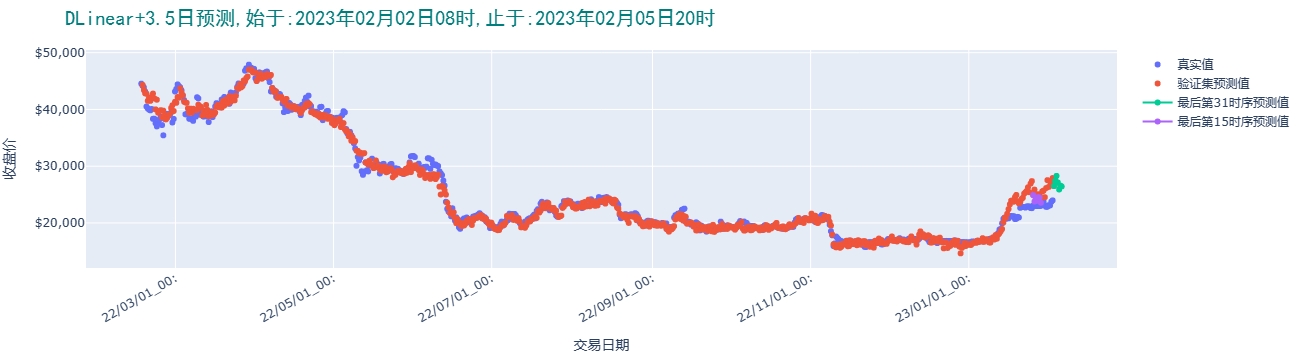

In [12]:
# 计算下预测的起始及结束日期,用于画图标注
Predict_Start_date = datetime.datetime.strftime(data0.index[-1].tz_convert('Asia/Shanghai'), "%Y年%m月%d日%H时")
Predict_End_date = data0.index[-1] + datetime.timedelta(
    hours=L_pred * 12
)  # 数据为每12小时一次数据
Predict_End_date = datetime.datetime.strftime(Predict_End_date.tz_convert('Asia/Shanghai'), "%Y年%m月%d日%H时")

# 尝试plotly绘制动态交互图
# fig = px.scatter(
#     x=data0.index[split:data_end],
#     y=y_true[split:, -1],
#     labels={'x':'日期','y':'$价格'},
#     title='BTC',
#     # animation_frame=np.arange(split_num,data_end),
# )
# 准备画布
# fig = go.Figure()
# 添加几组不同的数据
trace1 = go.Scatter(  #
    x=data0.index[-y_hat.shape[0]:],
    # y=y_true[-y_hat.shape[0]:, -1],
    y=data0.iloc[-y_hat.shape[0]:, -1],
    mode="markers",  # mode模式
    name="真实值",
    showlegend=True,
    xhoverformat="%y/%m/%d_%H:00",
    yhoverformat="$000,.0f",
    # hovertemplate='日期:%{x},价格: %{y:$.0f}',
)
trace2 = go.Scatter(  #
    x=data0.index[-y_hat.shape[0]:].shift(freq="12h"),  # 预测是偏离12个小时,即一个时刻
    y=y_hat[:, 0, 0],
    mode="markers",  # mode模式
    name="验证集预测值",
    showlegend=True,
    xhoverformat="%y/%m/%d_%H:00",
    yhoverformat="$000,.0f",
    # hovertemplate='日期:%{x},价格: %{y:$.0f}',
)

trace_data = [trace1, trace2]
# fig.add_trace(

# )  # 名字
# # fig.update_layout()

layout = go.Layout(
    title=dict(
        text="DLinear+{}日预测,始于:{},止于:{}".format(
            L_pred / 2, Predict_Start_date, Predict_End_date
        ),
        font=dict(color="rgb(0,125,125)", family="SimHei", size=20),
    ),
    margin=dict(l=50, b=10, t=50, r=15, pad=0),  # pad参数是刻度与标签的距离
    xaxis=dict(title="交易日期", tickangle=-30, tickformat='%y/%m/%d_%H:'),  # 设置坐标轴的标签
    yaxis=dict(title="收盘价", tickformat='$000,.0f'),
    # calendar=
    # template='presentation',
    # template='simple_white'
    # template='gridon',
    # template='plotly'
)
fig = go.Figure(data=trace_data, layout=layout)

for N in np.arange(Batch_size - 1, 0, -16):
    # last_hat_draw = last_hat[N, :]
    fig.add_trace(
        go.Scatter(  #
            x=pd.date_range(
                start=data0.index[-Batch_size + N] + datetime.timedelta(hours=12),
                periods=7,
                freq='12H',
            ),
            # y=last_hat_draw,
            y=y_hat[-Batch_size+N, :, 0],
            mode="markers+lines",  # mode模式
            name="最后第{}时序预测值".format(N),
            showlegend=True,
            xhoverformat="%y/%m/%d_%H:00",
            yhoverformat="$000,.0f",
            # hovertemplate='日期:%{x},价格: %{y:$.0f}',
        )
    )

fig.write_html('./checkpoint/LTSF_Linear&FF_230202.html',
                include_plotlyjs=True, auto_open=False)    
fig.show()

In [ ]:
import keras_tuner as kt


# 定义超参空间Class
class HypermodelSpace(kt.HyperModel):
    def build(self, hp):
        # 定义超参选项
        hp_Batch_size = hp.Int("Batch_size", min_value=32, max_value=128, step=32)
        hp_kernel_size = hp.Int("kernel_size", min_value=24, max_value=60, step=1)
        hp_L_seq = hp.Int("L_seq", min_value=48, max_value=336, step=32)

        model = LTSF_FF_DLinear(
            seq_len=hp_L_seq,
            pred_len=L_pred,
            channels=in_features,
            kernel_size=hp_kernel_size,
        )

        return model

    def fit(self, hp, model, *args, **kwargs):
        hp_Batch_size = hp.get("Batch_size")
        hp_L_seq = hp.get("L_seq")

        dataset_train = xs_ys_dataset(
            data[:split, :],
            hp_L_seq,
            L_pred,
            hp_Batch_size,
            out_features,
            shuffle=True,
            buffer_size=10000,
        )

        dataset_val = xs_ys_dataset(
            data[split:, :],
            hp_L_seq,
            L_pred,
            hp_Batch_size,
            out_features,
            shuffle=True,
            buffer_size=10000,
        )

        EPOCHS = 20
        train_loss_results = []
        logs = {}  # 字典
        wait = 0
        best = np.infty  # 先设置一个无穷大的数字;

        patience = 20

        # # Assign the model to the callbacks.
        # for callback in callbacks:
        #     callback.model = model
        # callbacks.set_model(model=model)
        callbacks = tf.keras.callbacks.CallbackList(
            callbacks=[], add_history=True, add_progbar=True, model=model
        )

        @tf.function  # 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地执行。
        def train_step(dataset):  # dataset是xs与xs_timestamp合集
            xs, ys = dataset[0], dataset[1]

            # 求导,根据导数优化变量
            with tf.GradientTape() as tape:
                y_ = model(xs)
                loss_value = loss_object(ys, y_)
            gradients = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            # 计算metric: 每个单步经过batch次运算后,共batch次 loss的平均值
            train_loss.update_state(loss_value)
            train_MSE.update_state(ys, y_)
            return {"train_loss": train_loss.result(), "train_MSE": train_MSE.result()}

        @tf.function
        def test_step(dataset_val):  # validation, test 使用该单步训练
            xs, ys = dataset_val[0], dataset_val[1]
            y_ = model(xs)
            loss_value = loss_object(ys, y_)
            val_loss.update_state(loss_value)
            val_MSE.update_state(ys, y_)
            return {"val_loss": val_loss.result(), "val_MSE": val_MSE.result()}

        train_start = time.time()
        callbacks.on_train_begin(logs=logs)
        for epoch in range(EPOCHS):
            epoch_start = time.time()
            callbacks.on_epoch_begin(epoch, logs=logs)

            train_loss.reset_states()
            train_MSE.reset_states()

            for batch, batch_data in enumerate(dataset_train):
                callbacks.on_batch_begin(batch, logs=logs)
                callbacks.on_train_batch_begin(batch, logs=logs)
                train_dict = train_step(batch_data)
                logs["train_loss"] = train_dict["train_loss"]
                logs["train_MSE"] = train_dict["train_MSE"]

                # if batch % 10 == 0:  # 每n次batch,打印
                #     print(
                #         "Epoch {} Batch {} train_loss {:.4f} train_MSE {:.4f} ".format(
                #             epoch + 1, batch, train_loss.result(), train_MSE.result()
                #         )
                #     )
                callbacks.on_train_batch_end(batch, logs=logs)
                callbacks.on_batch_end(batch, logs=logs)
            # End epoch 每个epoch
            train_loss_results.append(train_loss.result())

            val_loss.reset_states()
            val_MSE.reset_states()
            for batch_data in dataset_val:
                callbacks.on_batch_begin(batch, logs=logs)
                callbacks.on_test_batch_begin(batch, logs=logs)
                test_step(batch_data)
                callbacks.on_test_batch_end(batch, logs=logs)
                callbacks.on_batch_end(batch, logs=logs)

            logs["val_loss"] = val_loss.result()
            logs["val_MSE"] = val_MSE.result()
            # --------------------
            # The early stopping strategy: stop the training if `val_loss` does not
            # decrease over a certain number of epochs.
            #             wait += 1
            #             if (
            #                 val_loss.result() < best
            #             ):  # 当loss变小,在改进时,计数器恢复为0,存储模型,实现总是存储最佳模型; 当n次loss不再变小,即触发
            #                 best = val_loss.result()
            #                 wait = 0

            #                 ckpt_save_path = ckpt_manager.save()  # 存weight
            #                 # print("Saving checkpoint for epoch {} at {}".format(epoch + 1, ckpt_save_path))
            #             if wait >= patience:
            #                 print(
            #                     "\nepoch:{}/{} - 共耗时:{:.2f}分,历{}次训练未见val_loss减少,故提前中止".format(
            #                         epoch + 1, EPOCHS, (time.time() - train_start) / 60, patience
            #                     )
            #                 )
            #                 break
            # --------------------

            if (epoch + 1) % 10 == 0:  # 每n次epoch,打印

                print(
                    "\nepoch:{}/{} - 耗时:{:.2f}分/总{:.2f}分; train_loss {:.4f} train_MSE {:.4f}; val_loss {:.4f} val_MSE {:.4f}".format(
                        epoch + 1,
                        EPOCHS,
                        (time.time() - epoch_start) / 60,
                        (time.time() - train_start) / 60,
                        train_loss.result(),
                        train_MSE.result(),
                        val_loss.result(),
                        val_MSE.result(),
                    )
                )
            # print("Time taken for 1 epoch: {} mins\n".format((time.time() - start) / 60))
            best = min(
                best, float(logs["val_loss"])
            )  # 取最小的val_loss,val_loss需要转换成float数,才能被tunner接受
            callbacks.on_epoch_end(epoch, logs=logs)
        callbacks.on_train_end(logs=logs)
        print(
            "\nepoch:{}/{} - 共耗时:{:.2f}分,正常结束".format(
                epoch + 1, EPOCHS, (time.time() - train_start) / 60
            )
        )

        return best

In [ ]:
tuner = kt.Hyperband(
    hypermodel=HypermodelSpace(),
    objective=kt.Objective("val_loss", "min"),
    max_epochs=20,
    directory="Tunner_result",
    project_name="custom_training",
    overwrite=False,
)

In [ ]:
# 运行超参数搜索

start = time.time()
tuner.search(
    # inputs_train,
    epochs=20,
    # validation_data= inputs_val,
    # callbacks=callbacks, #callbacks是个objects,而这里必须是可以copy.deepcopy. callbacklists对象不能深度复制
)
end = time.time()
print("共耗时{:.3f}分钟".format((end - start) / 60))

# 在Docker上运行时,用于JupyterLab上自动关闭租用连接:
# import os
# 若释放前要保存环境并命名为 SnapName
# os.system("export $(cat /proc/1/environ |tr '\\0' '\\n' | grep MATCLOUD_CANCELTOKEN)&&/public/script/matncli node cancel -url https://matpool.com/api/public/node -save -name snapName")
# 若释放前不需要保存环境
# os.system("export $(cat /proc/1/environ |tr '\\0' '\\n' | grep MATCLOUD_CANCELTOKEN)&&/public/script/matncli node cancel -url https://matpool.com/api/public/node")

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=7)
for i in range(7):
    print(best_hps[i].values)

tuner.results_summary()